In [21]:
from __future__ import print_function 

%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
%matplotlib inline

import os, sys
import numpy as np
import time

import tensorflow as tf
from tensorflow.keras import backend as K

import pandas as pd
import pickle
import gc, re, copy
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils
from IPython.display import display

# Project imports 
from data import mnist_m as mnistm
from data import mnist
from data.label_shift import label_shift_linear, plot_labeldist, plot_splitbars
from data.tasks import load_task
from experiments.training import *
from bounds.bounds import *
from util.kl import *
from util.mmd import *
from util.misc import *
def find_best_model(all_data):
    best_error=1
    for a in np.sort(all_data['alpha'].unique()):
        for s in np.sort(all_data['sigma'].unique()):
            stratum = (all_data['sigma']==s)&(all_data['alpha']==a)


            err=all_data[stratum]['target_error']
            min_error=err.min()
            if min_error<best_error:
                best_error=min_error
                idx=find_minindex(min_error,err)
                gb = np.array(all_data[stratum]['disrho_bound'])[idx]
                bb = np.array(all_data[stratum]['beta_bound'])[idx]   
                mb = np.array(all_data[stratum]['mmd_bound'])[idx]
                ib = np.array(all_data[stratum]['iw_bound'])[idx]

    bounds=[gb,bb,mb,ib]
    return best_error, bounds

def find_best_bounds(all_data):
    """
    find best parameters and the minimum bound values as well as associated target errors for each bound 
    """
    best_gb=100
    best_bb=100
    best_mb=100
    best_ib=100
    for a in np.sort(all_data['alpha'].unique()):
        for s in np.sort(all_data['sigma'].unique()):
            #for e in [0.01]:#np.sort(D['epsilon'].unique()):#[0.01]:
            stratum = (all_data['sigma']==s)&(all_data['alpha']==a)#&(all_data['epsilon']==e)

            gb = all_data[stratum]['disrho_bound']
            bb = all_data[stratum]['beta_bound']       
            mb = all_data[stratum]['mmd_bound']
            ib = all_data[stratum]['iw_bound']

            min_gb=gb.min()
            min_bb=bb.min()
            min_mb=mb.min()
            min_ib=ib.min()

            if min_gb<best_gb:
                best_gb=min_gb
                idx=find_minindex(min_gb,gb)
                w_gb=np.array(all_data[stratum]['target_error'])[idx]
                gbparam=[a,s]

            if min_bb<best_bb:
                best_bb=min_bb
                idx=find_minindex(min_bb,bb)
                w_bb=np.array(all_data[stratum]['target_error'])[idx]
                bbparam=[a,s]
            if min_mb<best_mb:
                best_mb=min_mb
                idx=find_minindex(min_mb,mb)
                w_mb=np.array(all_data[stratum]['target_error'])[idx]
                mbparam=[a,s]

            if min_ib<best_ib:
                best_ib=min_ib
                idx=find_minindex(min_ib,ib)
                w_ib=np.array(all_data[stratum]['target_error'])[idx]
                ibparam=[a,s]
    best_errors = [w_gb, w_bb, w_ib, w_mb]
    best_bounds = [best_gb, best_bb, best_ib, best_mb]
    ### do something with the parameters?
    return best_errors, best_bounds
def find_minindex(minima,df):
    ## stupid function as all the indices are lost when saving results somehow
    j=0
    idx=0
    for i in df:
                if np.abs(i-minima)<=1e-4:
                    idx=j
                    break
                j+=1
    return idx


# Hyper-parameters
task = 2

architecture="resnet"
binary=True
#project_folder="/cephyr/users/adambre/Alvis/mnist_transfer/"
project_folder="/cephyr/NOBACKUP/groups/snic2021-23-538/mnist_transfer/"
if binary:
    results_folder = project_folder+"results/task"+str(task)+"/Binary/"+str(architecture)
else:
    results_folder = project_folder+"results/task"+str(task)+"/"+str(architecture)
plot_folder="/cephyr/users/adambre/Alvis/mnist_transfer/pics/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
r_files = [f for f in os.listdir(results_folder) if ('results.pkl' in f and not 'prior_results.pkl' in f)]

D = pd.DataFrame({})

# print(len(r_files))
# print(r_files)
# sys.exit(-1)
for r in r_files: 
    Dr = pd.read_pickle(os.path.join(results_folder, r))
    D = pd.concat([D, Dr], axis=0,sort=False)
D.head(20)
D['disrho_bound'] = np.nan
D['beta_bound'] = np.nan
D['mmd_bound'] = np.nan
D['iw_bound'] = np.nan

D = D.sort_values(by=[ 'alpha','weight_updates', 'sigma'])#

D.head(70)

,weight_updates,train_error,target_error,iw_error,target_iw_error,KL,e_s,e_t,d_tx,d_sx,...,m_bound,m_target,n_classifiers,seed,image_size,batch_size,disrho_bound,beta_bound,mmd_bound,iw_bound
0,0.0,0.511280,0.500350,0.045489,0.147155,4.569469e+06,0.311280,0.300350,0.000000,0.000000,...,70010,69990,5,5,32,128,NaN,NaN,NaN,NaN
0,0.0,0.497825,0.501249,0.045588,0.134855,4.562626e+06,0.447825,0.451249,0.000000,0.000000,...,70010,69990,5,4,32,128,NaN,NaN,NaN,NaN
0,0.0,0.473767,0.552495,0.050331,0.159335,4.563359e+06,0.273767,0.352495,0.000003,0.000000,...,70010,69990,5,3,32,128,NaN,NaN,NaN,NaN
0,0.0,0.527679,0.476610,0.043396,0.130336,4.564944e+06,0.374417,0.323533,0.006152,0.006525,...,70010,69990,5,2,32,128,NaN,NaN,NaN,NaN
0,0.0,0.484198,0.551789,0.050456,0.173216,4.573186e+06,0.281237,0.348823,0.005932,0.005922,...,70010,69990,5,1,32,128,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,220.0,0.331034,0.573356,0.052076,0.199518,4.565676e+05,0.181615,0.419617,0.107478,0.098837,...,70010,69990,5,1,32,128,NaN,NaN,NaN,NaN
0,220.0,0.300363,0.600291,0.054661,0.213521,4.561355e+05,0.196166,0.481343,0.137897,0.108393,...,70010,69990,5,4,32,128,NaN,NaN,NaN,NaN
0,220.0,0.373645,0.579134,0.052647,0.186339,4.565850e+05,0.255389,0.454661,0.048947,0.036512,...,70010,69990,5,3,32,128,NaN,NaN,NaN,NaN
0,220.0,0.392969,0.533773,0.048621,0.172648,4.557220e+05,0.229466,0.368633,0.030281,0.027008,...,70010,69990,5,5,32,128,NaN,NaN,NaN,NaN


In [23]:
m_bound =D['m_bound'].values[0] #172250## for alpha=0.3 #172250 #
m_target =D['m_target'].values[0] # 89696#89696 #
delta = D['delta'].values[0]
"""
 ['weight_updates', 'train_error', 'target_error', 'KL', 'e_s', 'e_t',
       'd_tx', 'd_sx', 'error_std', 'target_error_std', 'e_s_std', 'e_t_std',
       'd_tx_std', 'd_sx_std', 'alpha', 'sigma', 'epsilon', 'checkpoint',
       'delta', 'm_bound', 'm_target', 'n_classifiers', 'seed',
       'disrho_bound', 'beta_bound', 'mmd_bound']
"""
"""
NOTE that the iw errors are normalised with the largest weight
"""


### have the value of beta_infinity ready to use for the final computation of the bounds
if task==2:
    beta_inf=10.986111
    MMD=1.41
elif task==6 or task==7:
    beta_inf=10.9908
    MMD=1.41 ##? 
else:
    beta_inf=-1
    MMD=1.41
    ###calculate mmd outside of loop
#MMD=calculate_mmd(4)
#print("MMD=",MMD)

    
 # calculate bounds
names=['weight_updates', 'train_error', 'target_error', 'iw_error', 'target_iw_error', 'KL', 'e_s', 'e_t',
       'd_tx', 'd_sx', 'error_std', 'target_error_std', 'e_s_std', 'e_t_std',
       'd_tx_std', 'd_sx_std', 'alpha', 'sigma', 'checkpoint',
       'delta', 'm_bound', 'm_target', 'n_classifiers',
       'disrho_bound', 'beta_bound', 'mmd_bound', 'iw_bound']
all_data=pd.DataFrame(columns=names)
for a in np.sort(D['alpha'].unique()):
    for s in np.sort(D['sigma'].unique()):
        dfs = []
        Dprime=pd.DataFrame(columns=names)
        for w in np.sort(D['weight_updates'].unique()):
            stratum = (D['sigma']==s)&(D['alpha']==a)&(D['weight_updates']==w)

            ##############################################################################
            ## we aggregate between all different seed instances for each weight update 
            ##############################################################################

            #@TODO:check that the result is ok after mean


            #@TODO: Why is this so hard to do????
            if(len(D[stratum])==0):
                pass
                #print("empty stratum")
            else:

                D2=pd.DataFrame({'alpha':a, 'sigma':s, 'checkpoint':D[stratum]['checkpoint'].values[0],
               'delta':D[stratum]['delta'].values[0], 'm_bound':D[stratum]['m_bound'].values[0], 
                'm_target':D[stratum]['m_target'].values[0],'n_classifiers':D[stratum]['n_classifiers'].values[0],
                'disrho_bound':D[stratum]['disrho_bound'].values[0], 'beta_bound':D[stratum]['beta_bound'].values[0], 
                'mmd_bound':D[stratum]['mmd_bound'].values[0],'image_size':D[stratum]['image_size'].values[0]}, index=[int(w)])

                columns_to_aggregate=['weight_updates', 'train_error', 'target_error','iw_error', 'target_iw_error', 'KL', 'e_s', 'e_t',
               'd_tx', 'd_sx', 'error_std', 'target_error_std', 'e_s_std', 'e_t_std',
               'd_tx_std', 'd_sx_std']

                A=D.loc[stratum,:]
                A=A[columns_to_aggregate].mean()
                A=pd.DataFrame({'weight_updates':A['weight_updates'], 'train_error': A['train_error'],
                                'target_error':A['target_error'], 'iw_error': A['iw_error'],
                                'target_iw_error':A['target_iw_error'], 'KL':A['KL'], 'e_s':A['e_s'],
                                'e_t':A['e_t'],'d_tx':A['d_tx'], 'd_sx':A['d_sx'], 'error_std':A['error_std'],
                                'target_error_std':A['target_error_std'],'e_s_std':A['e_s_std'],
                                'e_t_std':A['e_t_std'],'d_tx_std':A['d_tx_std'], 'd_sx_std':A['d_sx_std']}, index=[int(w)])



                D2=pd.concat([A,D2],axis=1)

                Dprime=Dprime.append(D2)

            #### once we have aggregated we redefine the stratum and calculate the boundparts as normal

        stratum = (Dprime['sigma']==s)&(Dprime['alpha']==a)


        if(len(Dprime[stratum])==0):
            pass
            #print("empty stratum")
        else:
            train_error = Dprime[stratum]['train_error'].values
            iw_error =Dprime[stratum]['iw_error'].values
            e_s = Dprime[stratum]['e_s'].values
            e_t = Dprime[stratum]['e_t'].values
            d_tx = Dprime[stratum]['d_tx'].values
            d_sx = Dprime[stratum]['d_sx'].values
            KL = Dprime[stratum]['KL'].values

            ##########################################
            # Calculate the parts of the bounds
            ##########################################

            # calculate disrho bound
            res, bestparam, boundparts = grid_search(train_error,e_s,e_t,d_tx,d_sx,KL,delta,m_bound,m_target)
            res_inf, _, _ = grid_search(train_error,e_s,e_t,d_tx,d_sx,KL,delta,1e16,1e16)


            if task==1 or task==4:
                bestparam2=[0,0] ## we cannot calculate the bound with no obvious overlap
                res2=0
                res2_inf=0
            else:
                # calculate beta bound
                [res2, bestparam2, boundparts2] = grid_search(train_error,e_s,e_t,d_tx,d_sx,KL,delta,m_bound,m_target,beta_bound=True,beta_inf=beta_inf)
                [res2_inf, _, _] = grid_search(train_error,e_s,e_t,d_tx,d_sx,KL,delta,1e16,1e16,beta_bound=True,beta_inf=beta_inf)

            # calculate mmd bound
            res3,bestparam3, boundparts3 = grid_search_single(train_error,KL,delta,m_bound,MMD=MMD)
            res3_inf,_,_ = grid_search_single(train_error,KL,delta,1e16,MMD=MMD)    
            
            ## iw bound
            res4, bestparam4, boundparts4 =grid_search_single(iw_error,KL,delta,m_bound,w_max=beta_inf)

            res4_inf, _,_ =grid_search_single(iw_error,KL,delta,1e16,w_max=beta_inf)
            ## save the results
            Dprime.loc[stratum,'disrho_bound'] = res
            Dprime.loc[stratum,'disrho_bound_inf'] = res_inf
            Dprime.loc[stratum,'beta_bound'] = res2
            Dprime.loc[stratum,'beta_bound_inf'] = res2_inf
            Dprime.loc[stratum,'mmd_bound'] = res3
            Dprime.loc[stratum,'mmd_bound_inf'] = res3_inf
            Dprime.loc[stratum,'iw_bound']=res4
            Dprime.loc[stratum,'iw_bound_inf']=res4_inf
            A=np.zeros(len(res))
            if len(res)<5:
                A=-1
            else:
                A[0]=bestparam[0]
                A[1]=bestparam[1]
                A[2]=bestparam2[0]
                A[3]=bestparam2[1]
                A[4]=bestparam3
                A[5]=bestparam4
            # saves disrho bound params first and then beta bound; a,omega
            Dprime.loc[stratum,'params'] = A
            #print(Dprime)
            ### concatenate the results into the same shared dataframe
            #all_data=pd.concat([all_data,Dprime],axis=1)
            all_data=all_data.append(Dprime)
print(all_data)

#### save the aggregated data to disk

if binary:
    result_path = project_folder+"results/task"+str(task)+"/Binary/"+"aggregated_"+str(architecture)+".pkl"
else:
    result_path = project_folder+"results/task"+str(task)+"/"+"aggregated_"+str(architecture)+".pkl"
all_data.to_pickle(result_path)

Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsea

sigma: 0.00030000000000000003
sigma: 0.003
sigma: 0.03
sigma: 0.00030000000000000003
sigma: 0.003
sigma: 0.03
sigma: 0.00030000000000000003
sigma: 0.003
sigma: 0.03
sigma: 0.00030000000000000003
sigma: 0.003
sigma: 0.03
sigma: 0.00030000000000000003
sigma: 0.003
sigma: 0.03
sigma: 0.00030000000000000003
sigma: 0.003
sigma: 0.03
sigma: 0.00030000000000000003
sigma: 0.003
sigma: 0.03
sigma: 0.00030000000000000003
sigma: 0.003
sigma: 0.03
sigma: 0.00030000000000000003
sigma: 0.003
sigma: 0.03
sigma: 0.00030000000000000003
sigma: 0.003
sigma: 0.03
sigma: 0.00030000000000000003
sigma: 0.003
sigma: 0.03
sigma: 0.00030000000000000003
sigma: 0.003
sigma: 0.03
sigma: 0.00030000000000000003
sigma: 0.003
sigma: 0.03
sigma: 0.00030000000000000003
sigma: 0.003
sigma: 0.03
sigma: 0.00030000000000000003
sigma: 0.003
sigma: 0.03
sigma: 0.00030000000000000003
sigma: 0.003
sigma: 0.03
sigma: 0.00030000000000000003
sigma: 0.003
sigma: 0.03
sigma: 0.00030000000000000003
sigma: 0.003
sigma: 0.03
sigma: 0.0

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

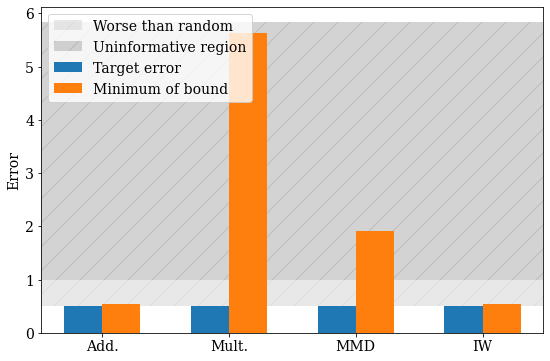

In [29]:
"""
Here we want to do barchart type images which show the best bounds before and after data dep
"""
task=2
architechtures=["lenet","fc","resnet"]
for arch in architectures:
    plt.clf()
    plt.figure(figsize=(9,6))
    results=project_folder+"results/task"+str(task)+"/"+"Binary/"+"aggregated_"+str(arch)+".pkl"
    all_data=pd.read_pickle(results)
    plt.rc('font', size=14, family='serif')
    for a in np.sort(all_data['alpha'].unique()):
        for s in np.sort(all_data['sigma'].unique()):
            stratum = (all_data['sigma']==s)&(all_data['alpha']==a)#&(all_data['epsilon']==e)
            print("sigma:",s)
            
            #### find the smallest bounds 
            gb = all_data[stratum]['disrho_bound']
            bb = all_data[stratum]['beta_bound']       
            mb = all_data[stratum]['mmd_bound']
            ib = all_data[stratum]['iw_bound']

            min_gb=gb.min()
            idx=find_minindex(min_gb,gb)
            w_gb=np.array(all_data[stratum]['target_error'])[idx]

            min_bb=bb.min()
            idx=find_minindex(min_bb,bb)
            w_bb=np.array(all_data[stratum]['target_error'])[idx]

            min_mb=mb.min()
            idx=find_minindex(min_mb,mb)
            w_mb=np.array(all_data[stratum]['target_error'])[idx]

            min_ib=ib.min()
            idx=find_minindex(min_ib,ib)
            w_ib=np.array(all_data[stratum]['target_error'])[idx]

            data1 = [w_gb, w_bb, w_mb, w_ib]
            data2 = [min_gb, min_bb, min_mb, min_ib]
            width =0.3
            labels = ['Add.', 'Mult.', 'MMD', 'IW']
            #### no title!
    #             if task==6:
    #                 #plt.title("CheXpert + ChestX-ray14 Mix, $\sigma_p=0.03$")
    #             elif task==2:
    #                # plt.title("MNIST + MNIST-M Mix, $\sigma_p=0.03$")
    plt.ylabel("Error")
    plt.xticks(range(len(data1)), labels)
    plt.axhspan(0.5, 1, color='lightgray', alpha=0.5, lw=0,hatch="/")
    plt.axhspan(1, max(max(data1),max(data2))+0.2, color='darkgray', alpha=0.5, lw=0, hatch="/")
    plt.bar(np.arange(len(data1))-width/2, data1, width=width)
    plt.bar(np.arange(len(data2))+ width/2, data2, width=width)

    plt.legend(["Worse than random","Uninformative region","Target error","Minimum of bound"],loc=2)
#     if s==0.03:
    #plt.savefig(plot_folder+"task"+str(task)+"_vacuous_"+str(arch)+".pdf")
    plt.savefig(plot_folder+"task"+str(task)+"_nonvacuous_"+str(arch)+".pdf")
#     plt.show()

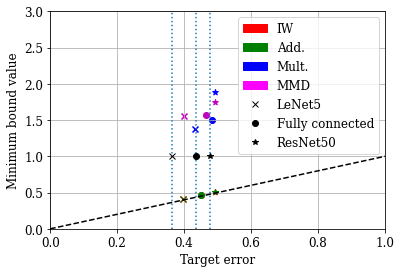

In [25]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
plt.rc('font', size=12, family='serif')
task=6

            
arch=["lenet","fc","resnet"]
markers={"lenet": "x",
         "fc": "o",
         "resnet": "*"}
marks=["x",
          "o",
          "*"]

fig, ax = plt.subplots()
for a in arch:
    results=project_folder+"results/task"+str(task)+"/"+"Binary/"+"aggregated_"+str(a)+".pkl"
    ### load aggregated data
    data=pd.read_pickle(results)
    ### compute the min bound and error
    err, bnd= find_best_bounds(data)
    best_error, _= find_best_model(data)

    ### plot
    
    plt.xlim([0,1])
    plt.ylim([0,3])
    plt.vlines(best_error,0,3,linestyles="dotted")
    plt.plot(best_error,1,c='k',marker=markers[a])
    plt.plot(err[0],bnd[0]  ,c='g',marker=markers[a])
    ax.scatter(err[1],bnd[1],c='b',marker=markers[a])
    ax.scatter(err[2],bnd[2],c='r',marker=markers[a])
    ax.scatter(err[3],bnd[3],c='m',marker=markers[a])
x=np.linspace(0,10,10)
plt.plot(x,x,'--k')
plt.grid(zorder=-100)
plt.ylabel("Minimum bound value")
plt.xlabel("Target error")
### patches for legend
red_patch = mpatches.Patch(color='red', label='IW')
green_patch = mpatches.Patch(color='green', label='Add.')
blue_patch = mpatches.Patch(color='blue', label='Mult.')
mag_patch = mpatches.Patch(color='magenta', label='MMD')
lenet = mlines.Line2D([], [],ls='', color='black', marker='x',
                           label='LeNet5')
fc = mlines.Line2D([], [],ls='', color='black', marker='o',
                           label='Fully connected')
resnet = mlines.Line2D([], [],ls='', color='black', marker='*',
                           label='ResNet50')
plt.legend(handles=[red_patch, green_patch, blue_patch,mag_patch,lenet,fc,resnet])


#plt.legend(["lenet disrho","lenet beta","lenet IW","fc disrho","fc beta","fc IW","Resnet50 disrho","Resnet50 beta","Resnet50 IW"])
#plt.title("MNIST mix")

#plt.legend(["Additive bound","Beta bound","IW bound"],loc=2)
#plt.show()
plt.savefig(plot_folder+"task"+str(task)+"_bestboundvserr.pdf")


In [ ]:

"""

plot of best model as in the lowest target error and its associated bounds

"""



arch=["lenet","fc","resnet"]
markers={"lenet": "x",
         "fc": "o",
         "resnet": "*"}
marks=["x",
          "o",
          "*"]

fig, ax = plt.subplots()
for a in arch:
    results=project_folder+"results/task"+str(task)+"/"+"Binary/"+"aggregated_"+str(a)+".pkl"
    ### load aggregated data
    data=pd.read_pickle(results)
    ### compute the min bound and error
    err, bnd= find_best_model(data)


    ### plot
    
    plt.xlim([0,1])
    plt.ylim([0,8])
    ax.scatter(err,bnd[0],c='g',marker=markers[a])
    ax.scatter(err,bnd[1],c='b',marker=markers[a])
    ax.scatter(err,bnd[2],c='m',marker=markers[a])
    ax.scatter(err,bnd[3],c='r',marker=markers[a])
x=np.linspace(0,10,10)
plt.plot(x,x,'--k')
plt.ylabel("Bound value")
plt.xlabel("Minimum target error")
### patches for legend
red_patch = mpatches.Patch(color='red', label='IW')
green_patch = mpatches.Patch(color='green', label='Add.')
blue_patch = mpatches.Patch(color='blue', label='Mult.')
mag_patch = mpatches.Patch(color='magenta', label='MMD')
lenet = mlines.Line2D([], [],ls='', color='black', marker='x',
                           label='LeNet5')
fc = mlines.Line2D([], [],ls='', color='black', marker='o',
                           label='Fully connected')
resnet = mlines.Line2D([], [],ls='', color='black', marker='*',
                           label='ResNet50')
plt.legend(handles=[red_patch, green_patch, blue_patch,mag_patch,lenet,fc,resnet])


#plt.legend(["lenet disrho","lenet beta","lenet IW","fc disrho","fc beta","fc IW","Resnet50 disrho","Resnet50 beta","Resnet50 IW"])
#plt.title("MNIST mix")
#plt.savefig(plot_folder+"task"+str(task)+"_boundvsbesterr.pdf")

Sigma = 0.00300 Alpha = 0.00000
Sigma = 0.03000 Alpha = 0.00000
Sigma = 0.00300 Alpha = 0.30000
Sigma = 0.03000 Alpha = 0.30000
Sigma = 0.00030 Alpha = 0.00000
Sigma = 0.00300 Alpha = 0.00000
Sigma = 0.03000 Alpha = 0.00000
Sigma = 0.00030 Alpha = 0.30000
Sigma = 0.00300 Alpha = 0.30000
Sigma = 0.03000 Alpha = 0.30000
Sigma = 0.00030 Alpha = 0.00000
Sigma = 0.00300 Alpha = 0.00000
Sigma = 0.03000 Alpha = 0.00000
Sigma = 0.00030 Alpha = 0.30000
Sigma = 0.00300 Alpha = 0.30000
Sigma = 0.03000 Alpha = 0.30000


<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

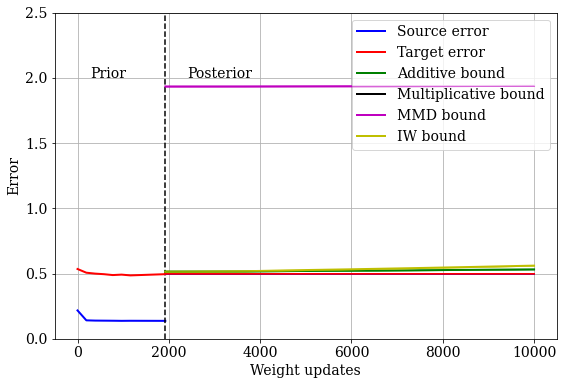

In [26]:
def compute_boundstd(boundtype, error_std, es_std, et_std, dtx_std, dsx_std, boundparams=[],BETA=0):
    L=len(error_std)
    a=boundparams.values[0]
    omega=boundparams.values[1]
    b=boundparams.values[2]
    c=boundparams.values[3]
    mmdparam=boundparams.values[4]
    iwparam=boundparams.values[5]
    if boundtype=="mult":
        bprime=BETA*(b/(1-np.exp(-b)))
        cprime=c/(1-np.exp(-c))
        bound=[]
        for i in range(L):
            a1=cprime/2*(dtx_std[i])
            a2=bprime*es_std[i]
            #a3[i]=(cprime/(m_t*c)+bprime/(m_s*b))*(2*KL[i]+np.log(2/delta)) no variation here
            bound.append(a1+a2)
    elif boundtype=="add":
        bound=[]
        aprime=2*a/(1-np.exp(-2*a))
        omegaprime=omega/(1-np.exp(-omega))
        for i in range(L):
            #lambda_rho=np.abs(e_t[i]-e_s[i])
            #dis_rho=np.abs(d_tx[i]-d_sx[i])
            a1=omegaprime*error_std[i]
            a2=aprime/2*(dtx_std[i]+dsx_std[i])
            # a3=(omegaprime/omega+aprime/a)*(KL[i]+np.log(3/delta))/m
            a4=es_std[i]+et_std[i]
            # a5=(aprime-1)/2
            bound.append(a1+a2+a4)
    elif boundtype=="iw":
        bound=[]
        #gamma_inv=(1-iwparam)
        for i in range(L):
            a1=(error_std[i])/iwparam
            # a2[i]=w_max*(KL[i]+np.log(1/delta))/(2*gamma*gamma_inv*m)
            bound.append(a1)
    else:
        ## mmd
        bound=[]
        #beta_inv=(1-mmdparam)
        for i in range(L):
            a1=error_std[i]/mmdparam
            # a2[i]=(KL[i]+np.log(1/delta))/(2*beta*beta_inv*m)
            #a3[i]=MMD ## fixed for now
            bound.append(a1)
    return bound
    

"""

plot of bound over training,

"""
plt.rc('font', size=14, family='serif')
task=6
arch=["lenet","fc","resnet"]
for arch in arch:
    results_folder = project_folder+"results/task"+str(task)+"/Binary/"+str(arch)
    plt.clf()
    results=project_folder+"results/task"+str(task)+"/"+"Binary/"+"aggregated_"+str(arch)+".pkl"
    all_data=pd.read_pickle(results)
    for a in [0,0.3]:#np.sort(all_data['alpha'].unique()):
        for s in np.sort(all_data['sigma'].unique()):
            #for e in [0.1]:
                print('Sigma = %.5f' % s, 'Alpha = %.5f' % a)
                ## pick out and load the relevant prior results
                r_files = [f for f in os.listdir(results_folder) if (str(int(a*100))+'_prior_results.pkl' in f)] 
                D_pr = pd.read_pickle(os.path.join(results_folder, r_files[0]))

                #get the number of weight_updates to add to posterior count

                max_prior_w=D_pr['weight_updates'].max()
                max_prior_w=np.max(max_prior_w)
                #prior_source=
                #prior_target=D_pr['target_error']

                stratum = (all_data['sigma']==s)&(all_data['alpha']==a)#&(all_data['epsilon']==e)

                ws = all_data[stratum]['weight_updates']

                e_so = all_data[stratum]['train_error']
                eiw_so = all_data[stratum]['iw_error']
                e_ta = all_data[stratum]['target_error']
                e_so_std = all_data[stratum]['error_std']
                e_ta_std = all_data[stratum]['target_error_std']
                e_t= all_data[stratum]['e_t']
                e_s= all_data[stratum]['e_s']
                d_tx= all_data[stratum]['d_tx']
                d_sx= all_data[stratum]['d_sx']
                KL = all_data[stratum]['KL']
                gb = all_data[stratum]['disrho_bound']
                bb = all_data[stratum]['beta_bound']       
                mb = all_data[stratum]['mmd_bound']
                ib = all_data[stratum]['iw_bound']
                ### plot whole bound 
                plt.clf()
                plt.figure(figsize=(9,6))
                plt.grid(zorder=-100)

                #### if there are more than one weightupdate for one point for some reason
                #### we should remove the smaller in error

                if a!=0:
                    ws+=max_prior_w ### add weightupdates from prior
                if a!=0:
                    ## add prior source and target
                    plt.plot(D_pr['weight_updates'][0],D_pr['train_error'][0] ,  lw=2, c='b')#label='Prior source error'
                    plt.plot(D_pr['weight_updates'][0],D_pr['target_error'][0],  lw=2, c='r')#label='Prior target error',
                    plt.axvline(max_prior_w,c='k', ls='dashed')
                    plt.figtext(0.18,0.73,"Prior")
                    if task==2:
                        plt.figtext(0.5,0.73,"Posterior") # task 2
                    else:
                        plt.figtext(0.33,0.73,"Posterior") # task 6
                plt.plot(ws, e_so, label='Source error', lw=2, c='b')
                plt.fill_between(ws, e_so-e_so_std, e_so+e_so_std, alpha=0.5, zorder=100, color='b')

                plt.plot(ws, e_ta, label='Target error', lw=2, c='r')
                plt.fill_between(ws, e_ta-e_ta_std, e_ta+e_ta_std, alpha=0.5, zorder=100, color='r')
                
                #### compute std of bounds and add to the vectors
                if task==2:
                    beta_inf=10.98611
                elif task==6 or task==7:
                    beta_inf=10.9908
                es_std=all_data[stratum]['e_s_std']
                et_std=all_data[stratum]['e_t_std']
                dtx_std=all_data[stratum]['d_tx_std']
                dsx_std=all_data[stratum]['d_sx_std']
                multstd=compute_boundstd("mult", e_so_std.values, es_std.values, et_std.values, dtx_std.values, dsx_std.values, all_data[stratum]['params'],beta_inf)
                #print(multstd)
                addstd=compute_boundstd("add", e_so_std.values, es_std.values, et_std.values, dtx_std.values, dsx_std.values, all_data[stratum]['params'],beta_inf)
                #print(addstd)
                mmdstd=compute_boundstd("mmd", e_so_std.values, es_std.values, et_std.values, dtx_std.values, dsx_std.values, all_data[stratum]['params'],beta_inf)
                #print(mmdstd)
                iwstd=compute_boundstd("iw", e_so_std.values, es_std.values, et_std.values, dtx_std.values, dsx_std.values, all_data[stratum]['params'],beta_inf)
                #print(iwstd)
                #sys.exit(-1)
                plt.plot(ws, gb, label=r'Additive bound', lw=2, c='g')
                plt.fill_between(ws, gb-addstd, gb+addstd, alpha=0.5, zorder=100, color='g')
                plt.plot(ws, bb, label='Multiplicative bound', lw=2, c='k')
                plt.fill_between(ws, bb-multstd, bb+multstd, alpha=0.5, zorder=100, color='k')
                plt.plot(ws, mb, label='MMD bound', lw=2, c='m')
                plt.fill_between(ws, mb-mmdstd, mb+mmdstd, alpha=0.5, zorder=100, color='m')
                plt.plot(ws, ib, label='IW bound', lw=2, c='y')
                plt.fill_between(ws, ib-iwstd, ib+iwstd, alpha=0.5, zorder=100, color='y')
                #plt.xlim(-100, 20000)

                plt.ylim(0, 2.5)
                plt.xlabel("Weight updates")
                plt.ylabel("Error")
                #if a==0:
                #    plt.title(r'No data, $\alpha=0$')
                #else:
                #    plt.title(r'$\alpha=$'+str(a))
                plt.legend(loc=1)
                #plt.show()
                #if a!=0:
                plt.savefig(plot_folder+str(task)+"_"+str(arch)+"training_"+str(a)+"_"+str(s)+".pdf")
                #plt.savefig(plot_folder+"big"+str(task)+"_"+str(architecture)+"training_"+str(a)+"_"+str(s)+".pdf")
                    #####plt.savefig("newchexresult_"+str(a)+".pdf")



            

Sigma = 0.03000 Alpha = 0.00000
Sigma = 0.00300 Alpha = 0.00000
Sigma = 0.03000 Alpha = 0.30000
Sigma = 0.00300 Alpha = 0.30000
Sigma = 0.03000 Alpha = 0.00000
Sigma = 0.00300 Alpha = 0.00000
Sigma = 0.03000 Alpha = 0.30000
Sigma = 0.00300 Alpha = 0.30000
Sigma = 0.03000 Alpha = 0.00000
Sigma = 0.00300 Alpha = 0.00000
Sigma = 0.03000 Alpha = 0.30000
Sigma = 0.00300 Alpha = 0.30000


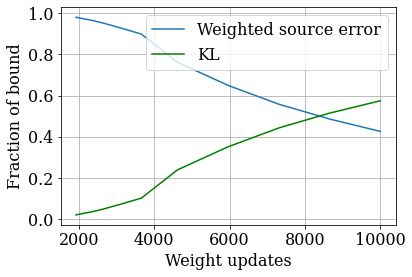

In [27]:
"""
plot the contribution of each constituent part for each of the bounds
"""

task=6
MMD=1.41
if task==2:
    beta_inf=10.986111
    MMD=1.41
elif task==6 or task==7:
    beta_inf=10.9908
plt.rc('font', size=16, family='serif')
architectures=["lenet","fc","resnet"]
for arch in architectures:
    results=project_folder+"results/task"+str(task)+"/"+"Binary/"+"aggregated_"+str(arch)+".pkl"
    all_data=pd.read_pickle(results)
    for a in [0,0.3]:#np.sort(all_data['alpha'].unique()):
        results_folder = project_folder+"results/task"+str(task)+"/Binary/"+str(arch)
        ## pick out and load the relevant prior results
        r_files = [f for f in os.listdir(results_folder) if (str(int(a*100))+'_prior_results.pkl' in f)] 
        D_pr = pd.read_pickle(os.path.join(results_folder, r_files[0]))
        #print(D_pr.sum())
        #sys.exit(-1)

        for s in [0.03,0.003]:
            #for e in [0.01]:
            print('Sigma = %.5f' % s, 'Alpha = %.5f' % a)

            stratum = (all_data['sigma']==s)&(all_data['alpha']==a)&(all_data['image_size']==32)

            delta=all_data[stratum]['delta'].values[0]
            #get the num weightupdates to add to posterior count
            max_prior_w=D_pr['weight_updates'].max()
            max_prior_w=np.max(max_prior_w)

            ws = all_data[stratum]['weight_updates']
            if a!=0:
                ws+=max_prior_w
            e_so = all_data[stratum]['train_error']
            eiw_so = all_data[stratum]['iw_error']
            e_ta = all_data[stratum]['target_error']
            e_so_std = all_data[stratum]['error_std']
            e_ta_std = all_data[stratum]['target_error_std']
            e_t= all_data[stratum]['e_t']
            e_s= all_data[stratum]['e_s']
            d_tx= all_data[stratum]['d_tx']
            d_sx= all_data[stratum]['d_sx']
            KL = all_data[stratum]['KL']
            gb = all_data[stratum]['disrho_bound']
            bb = all_data[stratum]['beta_bound']       
            mb = all_data[stratum]['mmd_bound'] 
            ib = all_data[stratum]['iw_bound']
            #just calculate the bound for each stratum and then plot the resulting proportions in a plot
        #### disrho


            m=all_data[stratum]['m_bound'].values[0]
            m_t=all_data[stratum]['m_target'].values[0]
            alp=all_data[stratum]['params'].values[0]
            omega=all_data[stratum]['params'].values[1]
            L=len(all_data[stratum])
            bound=[]
            aprime=2*alp/(1-np.exp(-2*alp))
            omegaprime=omega/(1-np.exp(-omega))
            a1=np.zeros(L)
            a2=np.zeros(L)
            a3=np.zeros(L)
            a4=np.zeros(L)
            a5=np.zeros(L)
            for i in range(L):
                dis_rho=np.abs(e_t.values[i]-e_s.values[i])
                lambda_rho=np.abs(d_tx.values[i]-d_sx.values[i])
                a1[i]=omegaprime*e_so.values[i]
                a2[i]=aprime/2*(dis_rho)
                a3[i]=(omegaprime/omega+aprime/alp)*(KL.values[i]+np.log(3/delta))/m
                a4[i]=lambda_rho
                a5[i]=(aprime-1)/2
                bound.append(a1[i]+a2[i]+a3[i]+a4[i]+a5[i])
            plt.clf()
            plt.grid(zorder=-100)
            plt.plot(ws,a1/bound)
            plt.plot(ws,a2/bound)
            plt.plot(ws,a3/bound)
            plt.plot(ws,a4/bound)
            plt.plot(ws,a5/bound)
            plt.xlabel("Weight updates")
            plt.ylabel("Fraction of bound")
            plt.legend(["Source error",r'Dis$_\rho$','KL',r'$\lambda_\rho$',"Constant"])
            #plt.show()
            plt.savefig(plot_folder+str(task)+"_"+str(arch)+"_"+"disrho_portion_"+str(a)+"_"+str(s)+".pdf")
            #sys.exit(-1)
        ### beta
            plt.clf()
            plt.grid(zorder=-100)
            #plt.rc('font', size=12, family='serif')
            #plt.clearfig
            BETA=beta_inf
            beta_bound=[]
            b=all_data[stratum]['params'].values[2]
            c=all_data[stratum]['params'].values[3]
            bprime=BETA*b/(1-np.exp(-b))
            cprime=c/(1-np.exp(-c))
            a1=np.zeros(L)
            a2=np.zeros(L)
            a3=np.zeros(L)
            for i in range(L):
                a1[i]=cprime/2*(d_tx.values[i])
                a2[i]=bprime*e_s.values[i]
                a3[i]=(cprime/(m_t*c)+bprime/(m*b))*(2*KL.values[i]+np.log(2/delta))
                beta_bound.append(a1[i]+a2[i]+a3[i])
            plt.plot(ws,a2/beta_bound)
            plt.plot(ws,a1/beta_bound)
            plt.plot(ws,a3/beta_bound)
            plt.xlabel("Weight updates")
            plt.ylabel("Fraction of bound")
            plt.legend([r'$e_s$',r'$d_{tx}$','KL'])
            #plt.show()
            plt.savefig(plot_folder+str(task)+"_"+str(arch)+"_"+"beta_portion_"+str(a)+"_"+str(s)+".pdf")
            
        ### MMD
            plt.clf()
            plt.grid(zorder=-100)
            #plt.rc('font', size=12, family='serif')
            #plt.clearfig

            mmd_bound=[]

            betaparam=all_data[stratum]['params'].values[4]

            a1=np.zeros(L)
            a2=np.zeros(L)
            a3=np.zeros(L)
            beta_inv=(1-betaparam)

            K=1
            for i in range(L):
                a1[i]=e_so.values[i]/betaparam
                a2[i]=(KL.values[i]+np.log(1/delta))/(2*betaparam*beta_inv*m)
                a3[i]=MMD ## fixed for now
                a4[i]=2*np.sqrt(K/m)*(2+np.sqrt(np.log(4/delta)))
                mmd_bound.append(a1[i]+a2[i]+a3[i]+a4[i])
            plt.plot(ws,a1/mmd_bound)
            plt.plot(ws,a3/mmd_bound)
            plt.plot(ws,a2/mmd_bound)
            plt.xlabel("Weight updates")
            plt.ylabel("Fraction of bound")
            plt.legend(['Source error','MMD','KL'])
            #plt.show()
            plt.savefig(plot_folder+str(task)+"_"+str(arch)+"_"+"mmd_portion_"+str(a)+"_"+str(s)+".pdf")

        ### IW
            plt.clf()
            plt.grid(zorder=-100)
            iw_bound=[]
            a1=np.zeros(L)
            a2=np.zeros(L)
            gamma=betaparam=all_data[stratum]['params'].values[4]
            gamma_inv=(1-gamma)
            for i in range(L):
                a1[i]=eiw_so.values[i]*BETA/gamma
                a2[i]=BETA*(KL.values[i]+np.log(1/delta))/(2*gamma*gamma_inv*m)
                iw_bound.append(a1[i]+a2[i])
            plt.plot(ws,a1/iw_bound)
            plt.plot(ws,a2/iw_bound,'g')
            plt.xlabel("Weight updates")
            plt.ylabel("Fraction of bound")
            plt.legend(['Weighted source error','KL'])
            #plt.show()
            plt.savefig(plot_folder+str(task)+"_"+str(arch)+"_"+"iw_portion_"+str(a)+"_"+str(s)+".pdf")

            ##### end of proportions plot


In [ ]:
"""
Plot the influence of varying alpha, find the lowest bound value for a specific alpha and save
"""
if task==2:
    beta_inf=10.986111
    MMD=1.41
elif task==6:
    beta_inf=10.9908
    MMD=1.41 ##? 
plt.rc('font', size=12, family='serif')
##### we calculate after the first epoch trained on the posterior, i.e. 2_1

    #for e in np.sort(all_data['epsilon'].unique()):
    beta_bound=[]
    disrho_bound=[]
    mmd_bound=[]
    iw_bound=[]
    for s in np.sort(all_data['sigma'].unique()):
        for a in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:#np.sort(D['alpha'].unique()):#np.sort(D['epsilon'].unique()):
            print('Sigma = %.5f' % s, 'Alpha = %.5f' % a)

            stratum = (all_data['sigma']==s)&(all_data['alpha']==a)#&(all_data["checkpoint"]=="2_5")



    #         ## compute the bound with all parameters =1/2 for consistency

            e_so = all_data[stratum]['train_error']
            eiw_so = all_data[stratum]['iw_error']
            e_ta = all_data[stratum]['target_error']
            e_so_std = all_data[stratum]['error_std']
            e_ta_std = all_data[stratum]['target_error_std']
            e_t=all_data[stratum]['e_t']
            e_s= all_data[stratum]['e_s']
            d_tx= all_data[stratum]['d_tx']
            d_sx= all_data[stratum]['d_sx']
            KL = all_data[stratum]['KL']


            #just calculate the bound for each stratum and then plot the resulting proportions in a plot
        #### disrho

            if len(all_data[stratum])==0:
                print("sum ting wong")
                print(stratum)
            else:
                m=all_data[stratum]['m_bound'].values[0]
                m_t=all_data[stratum]['m_target'].values[0]
                alp=1/2
                omega=1/2

                aprime=2*alp/(1-np.exp(-2*alp))
                omegaprime=omega/(1-np.exp(-omega))

                dis_rho=np.abs(e_t.values[0]-e_s.values[0])
                lambda_rho=np.abs(d_tx.values[0]-d_sx.values[0])
                a1=omegaprime*e_so.values[0]
                a2=aprime/2*(dis_rho)
                a3=(omegaprime/(omega)+aprime/(alp))*(KL.values[0]+np.log(3/delta))/m
                a4=lambda_rho
                a5=(aprime-1)/2
                disrho_bound.append(a1+a2+a3+a4+a5)



            ### beta
                BETA=beta_inf

                b=1/2
                c=1/2
                bprime=BETA*b/(1-np.exp(-b))
                cprime=c/(1-np.exp(-c))

                a1=cprime/2*(d_tx.values[0])
                a2=bprime*e_s.values[0]
                a3=(cprime/(m_t*c)+bprime/(m*b))*(2*KL.values[0]+np.log(2/delta))
                beta_bound.append(a1+a2+a3)
                #print(beta_bound)
                ### MMD


                betaparam=1/2

                beta_inv=(1-betaparam)

            ###  MMD
                a1=e_so.values[0]/betaparam
                a2=(KL.values[0]+np.log(1/delta))/(2*betaparam*beta_inv*m)
                a3=MMD ## fixed for now
                mmd_bound.append(a1+a2+a3)

            ### IW
                a1=eiw_so.values[0]/betaparam
                a2=BETA*(KL.values[0]+np.log(1/delta))/(2*betaparam*beta_inv*m)
                iw_bound.append(a1+a2)
        plt.xlabel(r"$\alpha$")
        plt.ylabel("Bound value")
        plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],disrho_bound)
        plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],beta_bound)
        plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],mmd_bound)
        plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],iw_bound)
    #plt.legend() 
#plt.savefig("mnistalphaplot_disrho.pdf")
#plt.savefig("chexalphadisrho.pdf")
#plt.show()

[0.003 0.03 ]
Sigma = 0.00300 Alpha = 0.10000
Sigma = 0.00300 Alpha = 0.20000
Sigma = 0.00300 Alpha = 0.30000
Sigma = 0.00300 Alpha = 0.40000
Sigma = 0.00300 Alpha = 0.50000
Sigma = 0.00300 Alpha = 0.60000
Sigma = 0.00300 Alpha = 0.70000
Sigma = 0.00300 Alpha = 0.80000
Sigma = 0.00300 Alpha = 0.90000
Sigma = 0.03000 Alpha = 0.10000
Sigma = 0.03000 Alpha = 0.20000
Sigma = 0.03000 Alpha = 0.30000
Sigma = 0.03000 Alpha = 0.40000
Sigma = 0.03000 Alpha = 0.50000
Sigma = 0.03000 Alpha = 0.60000
Sigma = 0.03000 Alpha = 0.70000
Sigma = 0.03000 Alpha = 0.80000
Sigma = 0.03000 Alpha = 0.90000
[0.0003 0.003  0.03  ]
Sigma = 0.00030 Alpha = 0.10000
Sigma = 0.00030 Alpha = 0.20000
Sigma = 0.00030 Alpha = 0.30000
Sigma = 0.00030 Alpha = 0.40000
Sigma = 0.00030 Alpha = 0.50000
Sigma = 0.00030 Alpha = 0.60000
Sigma = 0.00030 Alpha = 0.70000
Sigma = 0.00030 Alpha = 0.80000
Sigma = 0.00030 Alpha = 0.90000
Sigma = 0.00300 Alpha = 0.10000
Sigma = 0.00300 Alpha = 0.20000
Sigma = 0.00300 Alpha = 0.30000
Sig

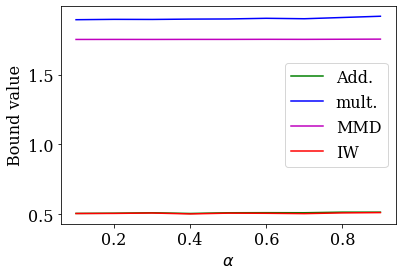

In [29]:
"""
plot of minimum bound for each alpha and see how that develops
"""
task=6
arch=["lenet","fc","resnet"]
for arch in arch:
    plt.clf()
    results=project_folder+"results/task"+str(task)+"/"+"Binary/"+"aggregated_"+str(arch)+".pkl"
    all_data=pd.read_pickle(results)
    plt.rc('font', size=16, family='serif')
    ##### we calculate after the first epoch trained on the posterior, i.e. 2_1

    beta_bound=np.ones(9)*1000
    disrho_bound=np.ones(9)*1000
    mmd_bound=np.ones(9)*1000
    iw_bound=np.ones(9)*1000
    print(np.sort(all_data['sigma'].unique()))

    for s in np.sort(all_data['sigma'].unique()):
        for a in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:#np.sort(D['alpha'].unique()):#np.sort(D['epsilon'].unique()):
            print('Sigma = %.5f' % s, 'Alpha = %.5f' % a)

            stratum = (all_data['sigma']==s)&(all_data['alpha']==a)#&(all_data["checkpoint"]=="2_5")
            if (len(all_data[stratum])==0):
                pass
            else:
                idx=int(a*10)-1

                gb = all_data[stratum]['disrho_bound']
                bb = all_data[stratum]['beta_bound']       
                mb = all_data[stratum]['mmd_bound'] 
                ib = all_data[stratum]['iw_bound']

                if min(gb)<disrho_bound[idx]:
                    disrho_bound[idx]=min(gb)
                if min(bb)<beta_bound[idx]:
                    beta_bound[idx]=min(bb)
                if min(mb)<mmd_bound[idx]:
                    mmd_bound[idx]=min(mb)
                if min(ib)<iw_bound[idx]:
                    iw_bound[idx]=min(ib)
    plt.xlabel(r"$\alpha$")
    plt.ylabel("Bound value")
    plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],disrho_bound,'g')
    plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],beta_bound,'b')
    plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],mmd_bound,'m')
    plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],iw_bound,'r')
    plt.legend(["Add.", "mult.", "MMD", "IW"])
    plt.savefig(plot_folder+str(task)+"_"+str(arch)+"_"+"alphaplot.pdf")

sigma: 0.003
[0.5113153100667649, 0.4615135657644934, 0.5008213142927077]
[0.4956722707813057, 0.42735907955761687, 0.4204145112379593]


<Figure size 432x288 with 0 Axes>

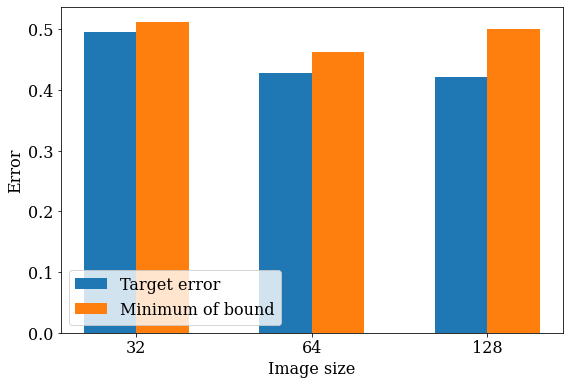

In [18]:
###### compare image sizes vs each other

task=6
arch="resnet"

plt.clf()
plt.figure(figsize=(9,6))
results_32=project_folder+"results/task"+str(task)+"/"+"Binary/"+"aggregated_"+str(arch)+".pkl"
results_other=project_folder+"results/task"+str(task+1)+"/"+"Binary/"+"aggregated_"+str(arch)+".pkl"
all_data=pd.read_pickle(results_32)
all_data2=pd.read_pickle(results_other)
all_data=pd.concat([all_data, all_data2])
plt.rc('font', size=16, family='serif')
#print(all_data)
best_error=[]
best_bound=[]
for a in [0.3]:
    for s in [0.003]:
        
        print("sigma:",s)
        
        for i in [32,64,128]:
            stratum = (all_data['sigma']==s)&(all_data['alpha']==a)&(all_data['image_size']==i)
            #all_data[stratum]
            err, bnd=find_best_bounds(all_data[stratum])
            idx=np.argmin(bnd)
            best_error.append(err[idx])
            best_bound.append(bnd[idx])
print(best_bound)
print(best_error)
width =0.3
plt.ylabel("Error")
plt.xlabel("Image size")
plt.xticks(range(len(best_bound)),labels=["32","64","128"])
#plt.axhspan(0.5, 1, color='lightgray', alpha=0.5, lw=0,hatch="/")
#plt.axhspan(1, max(max(data1),max(data2))+0.2, color='darkgray', alpha=0.5, lw=0, hatch="/")
plt.bar(np.arange(len(best_error))-width/2, best_error, width=width)
plt.bar(np.arange(len(best_bound))+ width/2, best_bound, width=width)
plt.legend(["Target error","Minimum of bound"],loc=3)
plt.savefig(plot_folder+"imagesizeplot.pdf")
